In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import signalz

from huffman import *
from utils import *
from pdd_parser import *

500
shift: 5551, 7166


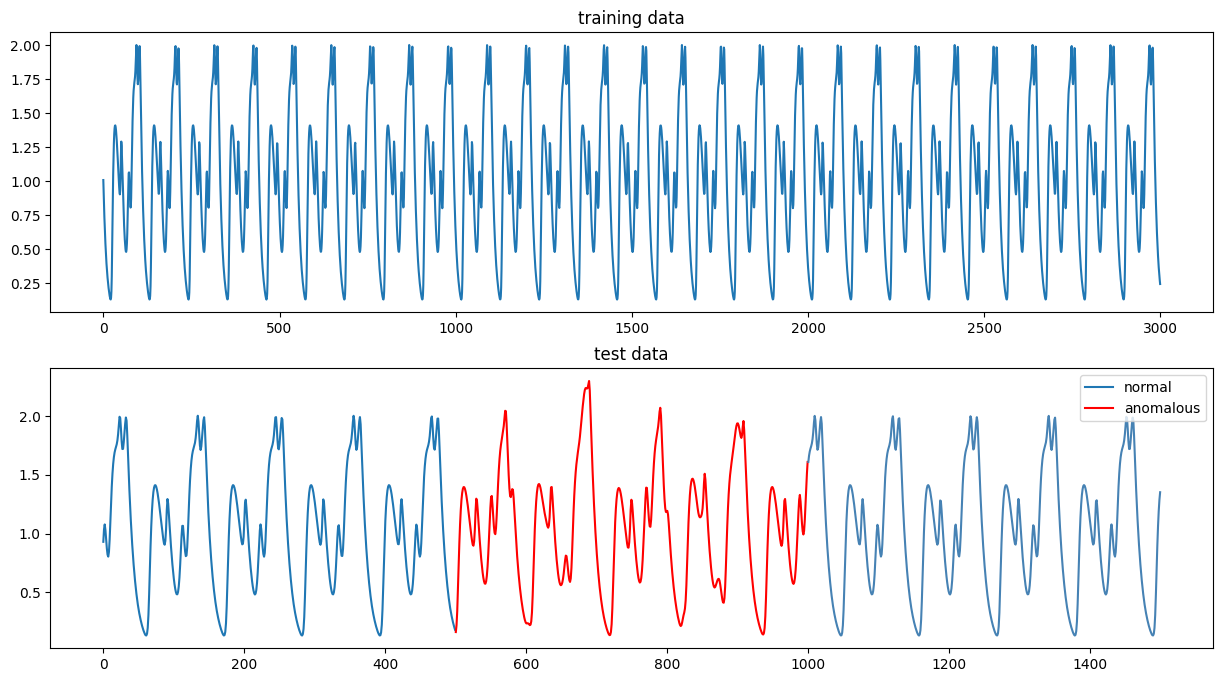

In [56]:
N = 10000
train_N = 3000
test_N = 1500
original_data = signalz.mackey_glass(N, a=0.2, b=0.5, c=0.9, d=23, e=10, initial=0.1)
train_set = original_data[1000:1000+train_N]
test_set = original_data[5000:5000+test_N]

anomaly_data = signalz.mackey_glass(N, a=0.3, b=0.8, c=0.9, d=23, e=10, initial=0.1)
anomaly_slice = anomaly_data[5500:6000]
print(len(anomaly_slice))

start, end = 0, 0
while abs(original_data[5500+start]-anomaly_slice[0]) > 1e-3:
  start += 1

while abs(original_data[6000+end]-anomaly_slice[-1]) > 1e-3:
  end += 1

print(f"shift: {5500+start}, {6000+end}")

test_set[:500] = original_data[5000+start:5500+start]
test_set[500:1000] = anomaly_slice
test_set[1000:] = original_data[6000+end:6000+end+500]

fig, axs = plt.subplots(2, 1, figsize=(15, 8))
axs[0].plot(np.arange(train_N), train_set)
axs[1].plot(np.arange(test_N)[:500], test_set[:500], label="normal")
axs[1].plot(np.arange(test_N)[500:1000], test_set[500:1000], color="red", label="anomalous")
axs[1].plot(np.arange(test_N)[1000:], test_set[1000:], color="steelblue")

axs[0].title.set_text("training data")
axs[1].title.set_text("test data")

plt.legend()
plt.show()

In [152]:
import time

### Train Markey-Glass Series

def train_markey_glass(max_D, num_bins, window_size):
  timer_op = time.time()

  min_val = min(train_set)
  max_val = max(train_set)
  print(f"preprocess: min={min(train_set)}, max={max(train_set)}, #bins={num_bins}")

  # Discretize the samples
  d_train_set = uniform_quantization(train_set, min_val, max_val, num_bins)
  # print(d_train_set[:10])

  # 训练PDD
  encoder = PDD(max_D=max_D)
  # 对于每个序列独立调用train，生成或更新PDD，记录当前频率

  for i_seq in range(0, len(train_set)-window_size, 1):
    subseq = d_train_set[i_seq:i_seq+window_size]
    encoder.train(subseq)
    # if i_seq % window_size == 0:
    #   print(f"{i_seq}/{len(train_set)}")
  # 遍历完整train data之后，基于当前频率构建code tree
  encoder.build_code_scheme()

  timer_ed = time.time()
  timeout = round((timer_ed-timer_op)*1e3)
  print(f"training time: {timeout}ms")


  # 使用code tree完成编码，完成测试
  train_num_phrases = []
  for i_seq in range(0, len(train_set)-WINDOW_SIZE, 1):
    subseq = d_train_set[i_seq:i_seq+WINDOW_SIZE]
    c_subseq = encoder.parse(subseq)
    train_num_phrases.append(len(c_subseq))

  avg_num_phrases = np.mean(train_num_phrases)

  print(f"train: {len(train_num_phrases)} samples, avg number of phrases: {avg_num_phrases}")

  d_test_set = uniform_quantization(test_set, min_val, max_val, num_bins)  # 归一化使用train的min-max
  test_num_phrases = []
  for i_seq in range(0, len(test_set)-window_size, 1):
    subseq = d_test_set[i_seq:i_seq+window_size]
    c_subseq = encoder.parse(subseq)
    test_num_phrases.append(len(c_subseq))

  test_anomalies_i = set()
  for (i, num) in enumerate(test_num_phrases):
    if abs(num - avg_num_phrases) > 0.2*window_size:
      test_anomalies_i.add(i)

  true_anomalies_i = set([i for i in range(500, 1000)])
  diff = [abs(test_num_phrases[i] - avg_num_phrases) for i in true_anomalies_i]
  print(np.histogram(diff, 10))

  TP = len(test_anomalies_i.intersection(true_anomalies_i))
  FP = len(test_anomalies_i.difference(true_anomalies_i))
  FN = len(true_anomalies_i.difference(test_anomalies_i))

  # print(f"test: {len(test_num_phrases)} samples, anomalies: {len(test_anomalies_i)}, precision: {TP/(TP+FP):.4f}, recall: {TP/(TP+FN):.4f}")
  metrics = {
      'timeout': timeout,
      'precision': round(TP/(TP+FP), 4) if (TP+FP)>0 else 0,
      'recall': round(TP/(TP+FN), 4) if (TP+FN)>0 else 0,
      'F1': round(2*TP/(2*TP+FP+FN), 4) if (TP+FP+FN)>0 else 0,
      'avg_num': avg_num_phrases
  }
  return encoder, metrics

In [153]:
MAX_D = [5, 10, 15, 20, 25]
WINDOW_SIZE = 100

ablation_max_D = []
for max_D in MAX_D:
  pdd_encoder, metrics = train_markey_glass(max_D, 100, WINDOW_SIZE)
  ablation_max_D.append(metrics)
  print(metrics)

preprocess: min=0.13171824585591063, max=2.0031574642055796, #bins=100
training time: 1614ms
train: 2900 samples, avg number of phrases: 21.0
(array([ 15,  16,  40,  26,  39, 111, 114,  50,  64,  25]), array([ 1. ,  6.1, 11.2, 16.3, 21.4, 26.5, 31.6, 36.7, 41.8, 46.9, 52. ]))
{'timeout': 1614, 'precision': 0.9461, 'recall': 0.808, 'F1': 0.8716, 'avg_num': 21.0}
preprocess: min=0.13171824585591063, max=2.0031574642055796, #bins=100
training time: 4272ms
train: 2900 samples, avg number of phrases: 11.0
(array([ 12,  12,  24,  45,   5,  95, 134,  66,  83,  24]), array([ 2. ,  7.8, 13.6, 19.4, 25.2, 31. , 36.8, 42.6, 48.4, 54.2, 60. ]))
{'timeout': 4272, 'precision': 0.9293, 'recall': 0.894, 'F1': 0.9113, 'avg_num': 11.0}
preprocess: min=0.13171824585591063, max=2.0031574642055796, #bins=100
training time: 6428ms
train: 2900 samples, avg number of phrases: 7.0
(array([ 14,  13,  20,  36,  14,  93, 132,  67,  65,  46]), array([ 3. ,  9.1, 15.2, 21.3, 27.4, 33.5, 39.6, 45.7, 51.8, 57.9, 64. 

In [111]:
NUM_BINS = [50, 100, 150, 200, 250]

ablation_resol = []
for num in NUM_BINS:
  pdd_encoder, metrics = train_markey_glass(15, num, WINDOW_SIZE)
  ablation_resol.append(metrics)
  print(metrics)

preprocess: min=0.13171824585591063, max=2.0031574642055796, #bins=50
training time: 6221ms
train: 2900 samples, avg number of phrases: 7.0
(array([ 19,  11,  36,  29,   5,  97, 131,  61,  70,  41]), array([ 2. ,  6.4, 10.8, 15.2, 19.6, 24. , 28.4, 32.8, 37.2, 41.6, 46. ]))
{'timeout': 6221, 'precision': 0.9461, 'recall': 0.808, 'F1': 0.8716}
preprocess: min=0.13171824585591063, max=2.0031574642055796, #bins=100
training time: 6052ms
train: 2900 samples, avg number of phrases: 7.0
(array([ 14,  13,  20,  36,  14,  93, 132,  67,  65,  46]), array([ 3. ,  9.1, 15.2, 21.3, 27.4, 33.5, 39.6, 45.7, 51.8, 57.9, 64. ]))
{'timeout': 6052, 'precision': 0.9185, 'recall': 0.924, 'F1': 0.9212}
preprocess: min=0.13171824585591063, max=2.0031574642055796, #bins=150
training time: 5622ms
train: 2900 samples, avg number of phrases: 7.0
(array([  9,  13,  19,  50,   9, 100,  56,  79,  86,  79]), array([ 9. , 14.9, 20.8, 26.7, 32.6, 38.5, 44.4, 50.3, 56.2, 62.1, 68. ]))
{'timeout': 5622, 'precision': 0.

<ipython-input-149-51e7de8acb0b>:33: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([line1, line2, line3], labels=labels, loc="upper center", ncol=4)


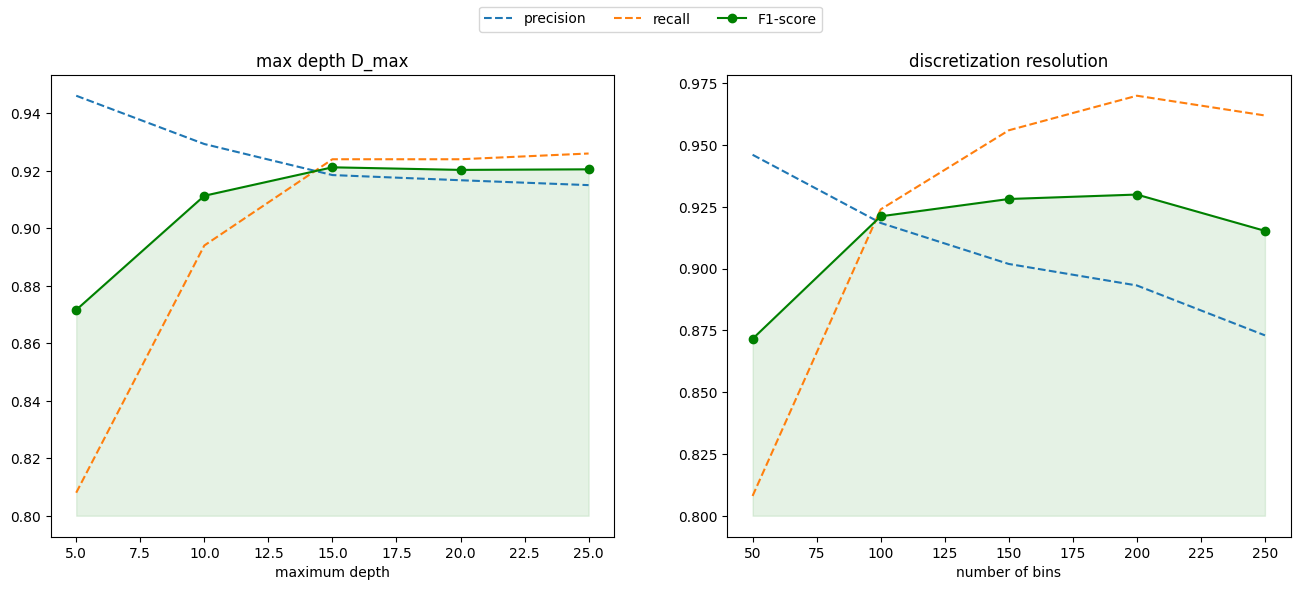

In [149]:
precisions = [metrics["precision"] for metrics in ablation_max_D]
recalls = [metrics["recall"] for metrics in ablation_max_D]
timeouts = [metrics["timeout"] for metrics in ablation_max_D]
F1s = [metrics["F1"] for metrics in ablation_max_D]
labels = ["precision", "recall", "F1-score"]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

line1 = axs[0].plot(MAX_D, precisions, linestyle='dashed', label='precision')
line2 = axs[0].plot(MAX_D, recalls, linestyle='dashed', label='recall')
line3 = axs[0].plot(MAX_D, F1s, color='green', label='F1', marker='o')
axs[0].fill_between(MAX_D, F1s, 0.8, color='green', alpha=.1)
axs[0].set_xlabel('maximum depth')


# ax12 = axs[0].twinx()
# line4 = ax12.plot(MAX_D, timeouts, color='crimson', label='training time', marker='x')
# # ax12.fill_between(MAX_D, timeouts, 0.8, color='crimson', alpha=.1)
# ax12.set_ylabel('time(ms)')

r_precisions = [metrics["precision"] for metrics in ablation_resol]
r_recalls = [metrics["recall"] for metrics in ablation_resol]
r_timeouts = [metrics["timeout"] for metrics in ablation_resol]
r_F1s = [metrics["F1"] for metrics in ablation_resol]

line1 = axs[1].plot(NUM_BINS, r_precisions, linestyle='dashed', label='precision')
line2 = axs[1].plot(NUM_BINS, r_recalls, linestyle='dashed', label='recall')
line3 = axs[1].plot(NUM_BINS, r_F1s, color='green', label='F1', marker='o')
axs[1].fill_between(NUM_BINS, r_F1s, 0.8, color='green', alpha=.1)
axs[1].set_xlabel('number of bins')


fig.legend([line1, line2, line3], labels=labels, loc="upper center", ncol=4)

axs[0].title.set_text("max depth D_max")
axs[1].title.set_text("discretization resolution")

# plt.legend()
plt.show()

<ipython-input-164-3282e0512644>:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([line1, line2], labels=["average number of phrases", "training time"], loc="upper center", ncols=2)


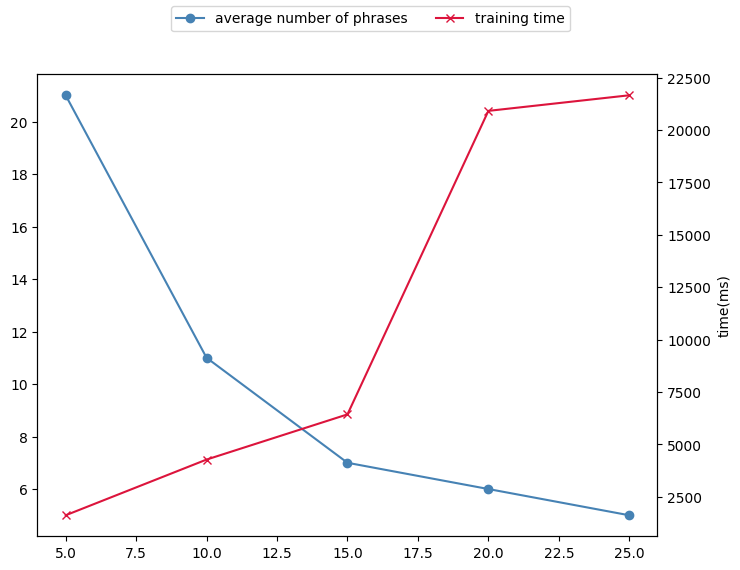

In [164]:
timeouts = [metrics["timeout"] for metrics in ablation_max_D]
avg_num_phrases = [metrics["avg_num"] for metrics in ablation_max_D]

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
line1 = axs.plot(MAX_D, avg_num_phrases, color='steelblue', label='average number of phrases', marker='o')
ax2 = axs.twinx()
line2 = ax2.plot(MAX_D, timeouts, color='crimson', label='training time', marker='x')
# axs.fill_between(MAX_D, avg_num_phrases, 0, color='steelblue', alpha=.1)
ax2.set_ylabel('time(ms)')

fig.legend([line1, line2], labels=["average number of phrases", "training time"], loc="upper center", ncols=2)
# plt.legend()
plt.show()